# Variational Autoencoder

In [4]:
import numpy as np
from sklearn import preprocessing

## generate random data

In [5]:
# matrixSize = 5

# A = np.random.rand(mean, matrixSize) * 2 
# B = np.dot(A, A.transpose())
# print(B)
# print(B.shape)

In [6]:
mean = np.array([20, 30])
print(mean.shape)
# mean = [0, 0,0,0,0]
cov = [[1, 0], [0, 100]]  # diagonal covariance

# cov = B.copy()
# print(cov.shape)
dataset = np.random.multivariate_normal(mean, cov, 10000)
dataset = dataset.astype(np.float32)
print(dataset)
dim = dataset.shape[1]
print(dataset.shape)

(2,)
[[18.335716 41.85181 ]
 [21.119665 27.820953]
 [19.716822 13.053251]
 ...
 [19.157578 59.310013]
 [20.16488  15.951777]
 [18.783895 22.357359]]
(10000, 2)


In [7]:
# dataset = preprocessing.normalize(dataset, axis=1)
# print(dataset[0,:])

## Model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import datasets, transforms

In [9]:
class VAE(nn.Module):
    def __init__(self, zdim, input_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_dim, 20)
        self.fc21 = nn.Linear(20, zdim) 
        self.fc22 = nn.Linear(20, zdim) 
        self.fc3 = nn.Linear(zdim, 20)
        self.fc4 = nn.Linear(20, input_dim)
        self.input_dim = input_dim
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn(mu.size(0),mu.size(1)) # assume eps normally distributed ~N(0,1)
#             eps = torch.randn_like(std)
            z = mu+ eps*std
#             return eps.mul(std).add_(mu)
            return z
#         else:
#             return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [10]:
def bce_loss(y_pred, y_true, input_dim):
#     print(y_pred)
#     print(y_true.view(-1, input_dim))
    BCE = F.binary_cross_entropy(y_pred, y_true.view(-1, input_dim), reduction='sum')
    return BCE

def mse_loss(y_pred, y_true):
    loss = nn.MSELoss(reduction='sum', size_average=False)
    return loss(y_pred, y_true)

def kld_Loss(mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD

def loss_function(y_pred, y_true, input_dim):
    recon_x, mu, logvar = y_pred
    x = y_true


    KLD = kld_Loss(mu, logvar)

    MSE = mse_loss(recon_x, x)
    return KLD + MSE


In [11]:
def train(model, num_epochs = 1, batch_size = 64, learning_rate = 0.0002):
    model.train() #train mode
    torch.manual_seed(42)
    
    train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    optimizer = optim.Adam(model.parameters(), learning_rate)
    
    for epoch in range(num_epochs):
      for data in train_loader:  # load batch
#           print(data)
          
          reconmulogvar = model(data)
          loss = loss_function(reconmulogvar, data, 5) # calculate loss
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
      
      print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))

In [12]:
batch_size = 256

model = VAE(2, 2)
train(model, num_epochs = 600, batch_size = batch_size, learning_rate = 0.005)

/Users/yukuai/opt/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch:1, Loss:1709.8008
Epoch:2, Loss:532.9507
Epoch:3, Loss:322.0637
Epoch:4, Loss:239.2320
Epoch:5, Loss:265.3474
Epoch:6, Loss:163.5926
Epoch:7, Loss:149.8694
Epoch:8, Loss:133.9010
Epoch:9, Loss:146.7171
Epoch:10, Loss:109.6656
Epoch:11, Loss:114.3205
Epoch:12, Loss:120.4683
Epoch:13, Loss:119.1102
Epoch:14, Loss:108.1171
Epoch:15, Loss:111.5079
Epoch:16, Loss:106.9694
Epoch:17, Loss:96.3725
Epoch:18, Loss:99.3311
Epoch:19, Loss:106.0827
Epoch:20, Loss:104.8576
Epoch:21, Loss:114.6615
Epoch:22, Loss:110.9889
Epoch:23, Loss:96.8748
Epoch:24, Loss:110.2607
Epoch:25, Loss:111.6641
Epoch:26, Loss:99.4480
Epoch:27, Loss:106.0434
Epoch:28, Loss:98.6446
Epoch:29, Loss:88.4544
Epoch:30, Loss:96.9379
Epoch:31, Loss:66.9175
Epoch:32, Loss:88.5268
Epoch:33, Loss:80.1538
Epoch:34, Loss:91.4827
Epoch:35, Loss:83.6359
Epoch:36, Loss:77.7966
Epoch:37, Loss:90.8663
Epoch:38, Loss:92.8900
Epoch:39, Loss:81.7058
Epoch:40, Loss:71.3469
Epoch:41, Loss:81.9108
Epoch:42, Loss:74.5888
Epoch:43, Loss:78.3

Epoch:347, Loss:70.0725
Epoch:348, Loss:66.8620
Epoch:349, Loss:67.0712
Epoch:350, Loss:76.1075
Epoch:351, Loss:68.1682
Epoch:352, Loss:69.2669
Epoch:353, Loss:56.3695
Epoch:354, Loss:71.4687
Epoch:355, Loss:71.0813
Epoch:356, Loss:61.7884
Epoch:357, Loss:64.1632
Epoch:358, Loss:56.0536
Epoch:359, Loss:62.0524
Epoch:360, Loss:59.8073
Epoch:361, Loss:64.7878
Epoch:362, Loss:62.1524
Epoch:363, Loss:70.5068
Epoch:364, Loss:81.9396
Epoch:365, Loss:64.0983
Epoch:366, Loss:60.3877
Epoch:367, Loss:68.2444
Epoch:368, Loss:71.0605
Epoch:369, Loss:69.2566
Epoch:370, Loss:74.8156
Epoch:371, Loss:70.5986
Epoch:372, Loss:74.2866
Epoch:373, Loss:62.1066
Epoch:374, Loss:60.6660
Epoch:375, Loss:73.3789
Epoch:376, Loss:61.7969
Epoch:377, Loss:70.4810
Epoch:378, Loss:66.5514
Epoch:379, Loss:59.8590
Epoch:380, Loss:58.3457
Epoch:381, Loss:68.8126
Epoch:382, Loss:68.4825
Epoch:383, Loss:53.0302
Epoch:384, Loss:67.5561
Epoch:385, Loss:89.3938
Epoch:386, Loss:67.0667
Epoch:387, Loss:58.4063
Epoch:388, Loss:

Epoch:689, Loss:63.2668
Epoch:690, Loss:63.3232
Epoch:691, Loss:65.1982
Epoch:692, Loss:68.1998
Epoch:693, Loss:58.3079
Epoch:694, Loss:69.6206
Epoch:695, Loss:68.3954
Epoch:696, Loss:71.3889
Epoch:697, Loss:61.6314
Epoch:698, Loss:72.7527
Epoch:699, Loss:63.0093
Epoch:700, Loss:57.2592
Epoch:701, Loss:59.7707
Epoch:702, Loss:60.3544
Epoch:703, Loss:69.5547
Epoch:704, Loss:58.8697
Epoch:705, Loss:70.2033
Epoch:706, Loss:64.4485
Epoch:707, Loss:59.5048
Epoch:708, Loss:70.0815
Epoch:709, Loss:72.7657
Epoch:710, Loss:69.5266
Epoch:711, Loss:65.2410
Epoch:712, Loss:64.6228
Epoch:713, Loss:65.7587
Epoch:714, Loss:63.7086
Epoch:715, Loss:60.4903
Epoch:716, Loss:69.1056
Epoch:717, Loss:58.5058
Epoch:718, Loss:62.4617
Epoch:719, Loss:63.4033
Epoch:720, Loss:62.6802
Epoch:721, Loss:61.0571
Epoch:722, Loss:57.2162
Epoch:723, Loss:62.9241
Epoch:724, Loss:60.6975
Epoch:725, Loss:66.8270
Epoch:726, Loss:53.7032
Epoch:727, Loss:77.5423
Epoch:728, Loss:57.1820
Epoch:729, Loss:65.7520
Epoch:730, Loss:

In [13]:
result = []
for i in range(2000):
  rinpt = torch.randn(1, 2)
  with torch.no_grad():
    si = model.decode(rinpt).numpy()
  result.append(si)

In [14]:

def get_most_similar_besides_i(simulated_data, test):
    min_idx = 100000
    min_distance = 1000000
    point2 = test
    for idx in range(len(simulated_data)):
        si = simulated_data[idx][0]
        distance = np.linalg.norm(si[:4] - point2[:4])
    #     print(distance)
        if distance < min_distance:
#             print(distance)
            min_idx = idx
            min_distance = distance
    return min_idx

In [15]:
result[504][0]

array([20.074053, 24.119696], dtype=float32)

In [16]:
dataset[0,:]

array([18.335716, 41.85181 ], dtype=float32)

In [17]:
testing_dataset = np.random.multivariate_normal(mean, cov, 3000)
testing_dataset = testing_dataset.astype(np.float32)

In [18]:
testing_dataset

array([[19.31825 , 32.841774],
       [18.692423, 37.12286 ],
       [21.28479 , 47.537174],
       ...,
       [20.975513, 17.598053],
       [20.972189, 25.200218],
       [19.653316, 21.096552]], dtype=float32)

In [19]:
# mean = np.array([20, 30, 50, 30, 40])

In [20]:
# get_most_similar_besides_i(result, testing_dataset[1])

In [21]:
# for i in range(testing_dataset.shape[0]):
#     idx = get_most_similar_besides_i(result, testing_dataset[i])
#     print(testing_dataset[i], endx="\t")
#     print(result[idx])

In [22]:
# testing dataset shape
result_new = np.array(result)[:,0,:]
result_new.shape

(2000, 2)

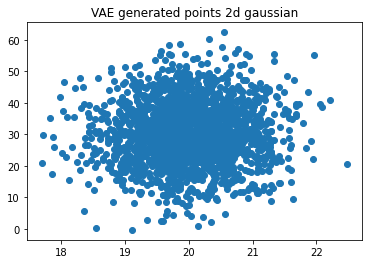

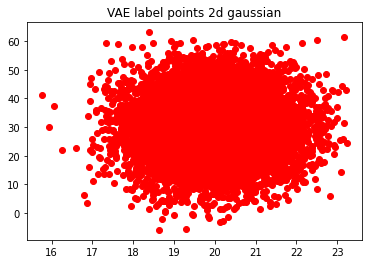

In [35]:
import matplotlib.pyplot as plt

plt.scatter(result_new[:, 0],  result_new[:, 1])
plt.title("VAE generated points 2d gaussian")
plt.show()
plt.scatter(dataset[:, 0], dataset[:, 1], c="r")
plt.title("VAE label points 2d gaussian")
plt.show()

In [24]:
# plt.hist(result_new[:,0])
# plt.show()
# plt.hist(result_new[:,1])
# plt.show()
# plt.hist(result_new[:,2])
# plt.show()
# plt.hist(result_new[:,3])
# plt.show()
# plt.hist(result_new[:,4])
# plt.show()

In [25]:
# var_0 = result_new[:,0].var()
# mean_0 = result_new[:,0].mean()
# var_1 = result_new[:,1].var()
# mean_1 = result_new[:,1].mean()
# var_2 = result_new[:,2].var()
# mean_2 = result_new[:,2].mean()
# var_3 = result_new[:,3].var()
# mean_3 = result_new[:,3].mean()
# var_4 = result_new[:,4].var()
# mean_4 = result_new[:,4].mean()
# result_mean = [mean_0, mean_1, mean_2, mean_3, mean_4]
# result_var = [var_0, var_1, var_2, var_3, var_4]

In [26]:
def kl_divergence(mean1, var1, mean2, var2):
    return np.log(var2/var1) + (var1 ** 2 + (mean1 - mean2) ** 2) / (2 * var2 ** 2) - 1/2

In [27]:

# for i in range(5):
#     kl = kl_divergence(mean1=result_mean[i], # generated data mean
#                   var1=result_var[i],        # generated data variance
#                   mean2=mean[i],             # train data mean
#                   var2=cov[i][i])            # train data variance
#     print("for dim {}, the kl divergence is {}".format(i, kl))

In [28]:
# ignore bellow

In [29]:
# class VAE2(nn.Module):
#     def __init__(self, zdim, input_dim):
#         super(VAE2, self).__init__()

#         self.fc1 = nn.Linear(input_dim, 10)
#         self.fc2 = nn.Linear(10, 20)
#         self.fc21 = nn.Linear(20, zdim)
#         self.fc22 = nn.Linear(20, zdim)
#         self.fc3 = nn.Linear(zdim, 20)
#         self.fc33 = nn.Linear(20, 10)
#         self.fc4 = nn.Linear(10, input_dim)
#         self.input_dim = input_dim
#     def encode(self, x):
#         h1 = F.relu(self.fc1(x))
#         h2 = F.relu(self.fc2(h1))
#         return self.fc21(h2), self.fc22(h2)

#     def reparameterize(self, mu, logvar):
#         if self.training:
#             std = torch.exp(0.5*logvar)
#             eps = torch.randn(mu.size(0),mu.size(1)) # assume eps normally distributed ~N(0,1)
# #             eps = torch.randn_like(std)
#             z = mu+ eps*std
# #             return eps.mul(std).add_(mu)
#             return z
# #         else:
# #             return mu

#     def decode(self, z):
#         h3 = F.relu(self.fc3(z))
#         h33 = F.relu(self.fc33(h3))
#         return self.fc4(h33)

#     def forward(self, x):
#         mu, logvar = self.encode(x.view(-1, self.input_dim))
#         z = self.reparameterize(mu, logvar)
#         return self.decode(z), mu, logvar

In [30]:
# batch_size = 128

# model = VAE2(5, 5)
# train(model, num_epochs = 300, batch_size = batch_size, learning_rate = 0.05)

In [31]:
# mean = [0, 0]
# cov = [[1, 0], [0, 100]]  # diagonal covariance

In [32]:
# import matplotlib.pyplot as plt
# x, y = np.random.multivariate_normal(mean, cov, 5000).T
# plt.plot(x, y, 'x')
# plt.axis('equal')
# plt.show()